# Klasyfikacja tweetów Elona Muska

### Projekt realizuje grupa:

*  Wiktor Bajor **249459**
*  Adam Kubiak **249480**


### Opis wykonywanego zadania: 

&nbsp; W ramach projektu grupa będzie realizować zadanie klasyfikacji binarnej tweetów Elona Muska. Wykonywane zadanie będzie opierać się o zebranie tweetów sławnych ludzi, takich jak politycy, przedsiębiorcy, sportowcy, celebryci, influencerzy oraz Elon Musk. 
Akwizycja danych będzie realizowana poprzez publiczny interfejs programowania aplikacji (API), udostępniony przez Twitter.  Przy czym możliwa ilość tweetów do pobrania to pięćset tysięcy, co powinno być wystarczającą ilością danych. Dzięki udostępnionemu API można uzyskać dostęp do takich danych jak, treść publikacji, godzina publikacji, lokalizacja, ilość polubień czy ilość retweetów. Po ukończeniu etapu akwizycji danych kolejnym zadaniem, będzie przeanalizowanie tweetów, mając na uwadze takie elementy jak ilość retweetów, ilość polubień, występowanie pewnych słów kluczowych czy też sentyment umieszczonego tekstu. Na podstawie dokonanej analizy zostaną wybrane najbardziej charakterystyczne cechy tweetów Elona Muska. Ostatnim elementem projektu będzie utworzenie i wytrenowanie (na bazie wcześniej wybranych najbardziej istotny cech) klasyfikatora, który będzie oceniał czy dany tweet był napisany przez Elona Muska czy też nie. Wykonana analiza oraz klasyfikator mogłyby zostać wykorzystane do stworzenia cyfrowego sobowtóra Elona Muska. 

### Eksploracyjna analiza danych

#### Pochodzenie danych

Dane pobierane są bezpośrednio z Twittera. Do akwizycji wykorzystane zostało API V2, udostępnione bezpośrednio przez Twitter oraz dedykowana biblioteka Tweepy, która umożliwiła wygodne pobieranie danych z wykorzystaniem języka Python3. 


Zdecydowano się na poddanie analizie kilka publicznych osób o zbliżonej ilości obserwatorów. Do wybrania odpowiednich kont wykorzystano stronę https://www.socialtracker.io/toplists/top-50-twitter-users-by-followers/, na której została zebrana lista 50 najbardziej popularnych kont. W trakcie wyboru kont starano się aby wybrane konta reprezentowały różne części społeczeństwa(politycy, celebryci, przedsiębiorcy, artyści oraz platformy medialne).

Finalnie wybrano:

* Elon Musk $-$ ~`115` mln obserwujących
* Barack Obama $-$ ~`133` mln obserwujących
* Justin Bieber $-$ ~`113` mln obserwujących
* Cristiano Ronaldo $-$ ~`104` mln obserwujących
* YouTube $-$ ~`77` mln obserwujących
* KimKardashian ~`74` mln obserwujących
* Ellen DeGeneres $-$ ~`77` mln obserwujących
* Twitter $-$ ~`64` mln obserwujących
* CNN $-$ ~`64` mln obserwujących
* Bill Gates $-$ ~`61` mln obserwujących
* Joe Biden $-$ ~`36` mln obserwujących


Skrypty realizujące pobieranie oraz zapisywanie tweetów w formacie, zawarte są w plikach `tweet_getter.ipynb` oraz `tweets_pd_frames.ipynb`.

### Opis zmiennych

Api Twittera umożliwia pobranie wielu danych w ramach projektu zdecydowano się na pobranie kolejnych danych:

* `created_at`(string w formacie daty) - jest to data zamieszczenia wpisu z dokładnością co do sekundy, tą informacje można wykorzystać do sprawdzenia aktywności użytkownika w trakcie doby
* `source`(string) - źródło publikacji wiadomości, na przykład czy wpis był wykonany z aplikacji z iPhone czy ze strony internetowej
* `possibly sensitive`(bool) - zawiera informacje czy dany wpis zawiera treści wrażliwe
* `lang`(string) - język wpisu
* `has_text`(binary integer value[0,1]) - informacja, czy wpis zawierał "czysty tekst"(bez emoji, linków, oznaczeń czy hashtagów)
* `has_link`(binary integer value[0,1]) - informacja, czy wpis zawierał link
* `has_hashtag`(binary integer value[0,1]) - informacja, czy wpis zawierał hashtag
* `has_emoji`(binary integer value[0,1]) - informacja, czy wpis zawierał emoji
* `sentiment`(float) - sentyment wpisu w skali od -1 do 1(wartość **2** oznacza, że "czysty wpis" nie zawiera tekstu) wyliczony z treści wpisu z wykorzystaniem biblioteki `TextBlob`(zastosowany tylko do anglojęzycznych wpisów)
* `subjectivity`(float) - subiektywność wpisu w skali od -1 do 1(wartość **2** oznacza, że "czysty wpis" nie zawiera tekstu) wyliczony z treści wpisu z wykorzystaniem biblioteki `TextBlob`(zastosowany tylko do anglojęzycznych wpisów)
* `retweet count`(int) - liczba 'podania dalej wpisu'
* `reply count`(int) - liczba odpowiedzi 
* `like count`(int) - liczba polubień wpisu
* `quote count`(int) - liczba cytowań wpisu
* `is Elon Musk`(binary integer value[0,1]) - identyfikuje czy dany jest wpis jest utworzony przez Elona Muska 


#### Wczytanie danych

Pobrane dane zostały zapisane w czterech plikach `*.csv`. 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_folder = 'user_data'

data_frame = pd.read_csv(f'{data_folder}/main_df.csv')
data_annotations_frame = pd.read_csv(f'{data_folder}/annotation_df.csv')
old_elon_basic = pd.read_csv(f'{data_folder}/old_elon_basic.csv')
old_elon_annotations = pd.read_csv(f'{data_folder}/old_elon_annotations.csv')


data_frame["created at"] = pd.to_datetime(data_frame["created at"])
old_elon_basic["created at"] = pd.to_datetime(old_elon_basic["created at"])

#### Podstawowa ramka danych

In [5]:
data_frame.head()

,is Elon Musk,created at,source,possibly sensitive,lang,has_text,has_link,has_hashtag,has_at,has_emoji,sentiment,subjectivity,retweet count,reply count,like count,quote count
0,1,2022-12-12 19:46:04+00:00,Twitter for iPhone,0,und,0,1,0,0,1,2.0,2.0,20135,14379,238424,3363
1,1,2022-12-12 19:36:52+00:00,Twitter for iPhone,0,en,1,1,0,0,0,0.0,0.0,27679,9635,118548,1714
2,1,2022-12-12 14:21:31+00:00,Twitter for iPhone,0,en,1,0,0,0,0,0.8,0.7,37603,27237,337208,4261
3,1,2022-12-12 12:25:32+00:00,Twitter for iPhone,0,en,1,0,0,0,0,0.0,0.0,66507,42222,470431,10681
4,1,2022-12-12 11:24:29+00:00,Twitter for iPhone,0,en,1,0,0,0,0,0.0,0.0,10073,6045,138343,522


### Opis zmiennych 

Poza podstawowymi informacjami Twitter umożliwia pobranie gotowych analiz tekstu. Utworzone analizy zawierają, do sześciu różnych analiz. Pięć pierwszych analiz zawiera informacje o dziedzinie wpisu oraz o istocie wpisu. Ostatnia, szósta analiza zawiera prawdopodobieństw trafności analizy, dziedzinę oraz istotę wpisu. Ostatnia analiza nie jest dostępna dla każdego wpisu.     

In [6]:
data_annotations_frame.head()

,is Elon Musk,context annotations domain 0,context annotations entity 0,context annotations domain 1,context annotations entity 1,context annotations domain 2,context annotations entity 2,context annotations domain 3,context annotations entity 3,context annotations domain 4,context annotations entity 4,context annotations domain 5,context annotations entity 5,annotations
0,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN
1,True,Person,Donald Trump,Politician,Donald Trump,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,News Vertical,News,News Vertical,Business & finance news,"[0.9636, 'Twitter', 'Other']"
2,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,"[0.9003, 'Covidians', 'Other']"
3,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN
4,True,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN


In [7]:
old_elon_data = pd.concat([old_elon_basic, old_elon_annotations], axis=1)
old_elon_data = old_elon_data.loc[:,~old_elon_data.columns.duplicated()].copy()

data_frame = pd.concat([data_frame, data_annotations_frame], axis=1)
data_frame = data_frame.loc[:,~data_frame.columns.duplicated()].copy()
data_frame = pd.concat([data_frame, old_elon_data], axis=0)

In [8]:
data_frame.head()

,is Elon Musk,created at,source,possibly sensitive,lang,has_text,has_link,has_hashtag,has_at,has_emoji,...,context annotations entity 1,context annotations domain 2,context annotations entity 2,context annotations domain 3,context annotations entity 3,context annotations domain 4,context annotations entity 4,context annotations domain 5,context annotations entity 5,annotations
0,1,2022-12-12 19:46:04+00:00,Twitter for iPhone,0,und,0,1,0,0,1,...,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN
1,1,2022-12-12 19:36:52+00:00,Twitter for iPhone,0,en,1,1,0,0,0,...,Donald Trump,Business Taxonomy,Financial Services Business,Business Taxonomy,Technology Business,News Vertical,News,News Vertical,Business & finance news,"[0.9636, 'Twitter', 'Other']"
2,1,2022-12-12 14:21:31+00:00,Twitter for iPhone,0,en,1,0,0,0,0,...,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,"[0.9003, 'Covidians', 'Other']"
3,1,2022-12-12 12:25:32+00:00,Twitter for iPhone,0,en,1,0,0,0,0,...,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN
4,1,2022-12-12 11:24:29+00:00,Twitter for iPhone,0,en,1,0,0,0,0,...,Technology Business,Person,Elon Musk,Interests and Hobbies Vertical,Business & finance,Interests and Hobbies Category,Leadership,Unified Twitter Taxonomy,Elon Musk,NaN


### Badanie brakujących zmiennych 

Twitter udostępnia dane, które są kompletne, ciężko znaleźć jakieś braki. 
W niektórych przypadkach brakuje analizy kontekstu wypowiedzi.
Brak ten nie jest istotny z punkt widzenia całego zbiory, ponieważ całkowity brak analizy tekstu występuje tylko dla kilku próbek.
Próbki obarczone tym problemem mogą zostać wykluczone.
Kolejnym elementem, który bywa wybrakowany jest treść wpisu(szczególnie w przypadku Elona Muska). Mimo braku treści wpisu, nadal informacje dostępne są dane o ilości odpowiedzi czy polubień, więc takie dane mogą zostać wykorzystane.

### Czyszczenie danych

In [9]:
data_frame.groupby(by='is Elon Musk')['source'].value_counts()

is Elon Musk  source                  
0             Twitter Web App             1868
              Twitter for iPhone          1805
              Twitter Media Studio         944
              SocialFlow                   808
              Sprout Social                649
              Sprinklr                     588
              Twitter Web Client           160
              swonkie                       12
              Twitter for Advertisers.       4
              TweetDeck                      3
              Twitter Ads                    2
              Arrow.                         1
              Instagram                      1
              Periscope                      1
              Twitter for  iPhone            1
              Twitter for Android            1
              Twitter for Mac                1
1             Twitter for iPhone           949
Name: source, dtype: int64

In [10]:
data_frame = data_frame.groupby('source').filter(lambda x : len(x) > 12)
data_frame.groupby(by='is Elon Musk')['source'].value_counts()

is Elon Musk  source              
0             Twitter Web App         1868
              Twitter for iPhone      1805
              Twitter Media Studio     944
              SocialFlow               808
              Sprout Social            649
              Sprinklr                 588
              Twitter Web Client       160
1             Twitter for iPhone       949
Name: source, dtype: int64

In [11]:
data_frame.groupby(by='is Elon Musk')['lang'].value_counts()

is Elon Musk  lang
0             en      6092
              und      229
              pt       119
              art      101
              zxx       89
              it        62
              es        54
              qst       14
              fr        13
              qme       13
              tl         9
              de         4
              et         4
              cy         3
              qht        3
              in         2
              ja         2
              nl         2
              tr         2
              ca         1
              ht         1
              lt         1
              qam        1
              ro         1
1             en       795
              zxx      100
              und       13
              art        5
              fr         5
              qst        5
              de         4
              pt         4
              es         3
              da         2
              et         2
              in         2
         

In [12]:
values = ['en','art','zxx']
data_frame = data_frame[data_frame.lang.isin(values) == True]
data_frame.groupby(by='is Elon Musk')['lang'].value_counts()

is Elon Musk  lang
0             en      6092
              art      101
              zxx       89
1             en       795
              zxx      100
              art        5
Name: lang, dtype: int64

### Analiza danych numerycznych 

W przypadku dostępnych danym, kilka zmiennych to dane numeryczne:

* `like count`
* `retweet count`
* `quote count`
* `reply count`
* `sentiment`

Żeby lepiej przyjrzeć się danym numerycznym, wykorzystano podstawowe własności.

#### Średnia

Analizując wartości średnie liczby polubień, odpowiedzi, cytowań czy podawania dalej można zauważyć, że 
każda wartości poza średnim sentymentem jest kilkukrotnie wyższa. Można zauważyć iż największa różnica bo
aż dziesięciokrotna jest w średniej liczbie odpowiedzi na wpis. Co może świadczyć o tym iż wpisy Elona Muska bardziej 
angażują społeczność.

In [13]:
numeric_columns = ["like count","retweet count", 'quote count', 'reply count', 'sentiment', 'subjectivity']
data_frame.groupby(by='is Elon Musk')[numeric_columns].max()

,like count,retweet count,quote count,reply count,sentiment,subjectivity
is Elon Musk,,,,,,
0,3191530,610409,191703,110841,2.0,2.0
1,4780372,681651,179586,317377,2.0,2.0


#### Mediana

Porównując mediane wpisów Elona Muska do pozostałych użytkowników, można zauważyć iż w przypadku wpisów
Elona Muska mediany są bardziej zbliżone do średnich niż w przypadku pozostałych użytkowników. 
Szczególnie widać to przy ilości cytowań. Takie zachowanie może wynikać z faktu, że Elon ma bardziej stałą grupę
odbiorców, natomiast w przypadku innych reakcje mogą bardziej wynikać ze szczególnych zdarzeń.   


In [14]:
data_frame.groupby(by='is Elon Musk')[numeric_columns].median()

,like count,retweet count,quote count,reply count,sentiment,subjectivity
is Elon Musk,,,,,,
0,4126.5,443.5,81.0,280.0,0.109545,0.400
1,165382.0,12078.0,1462.5,10381.5,0.000000,0.375


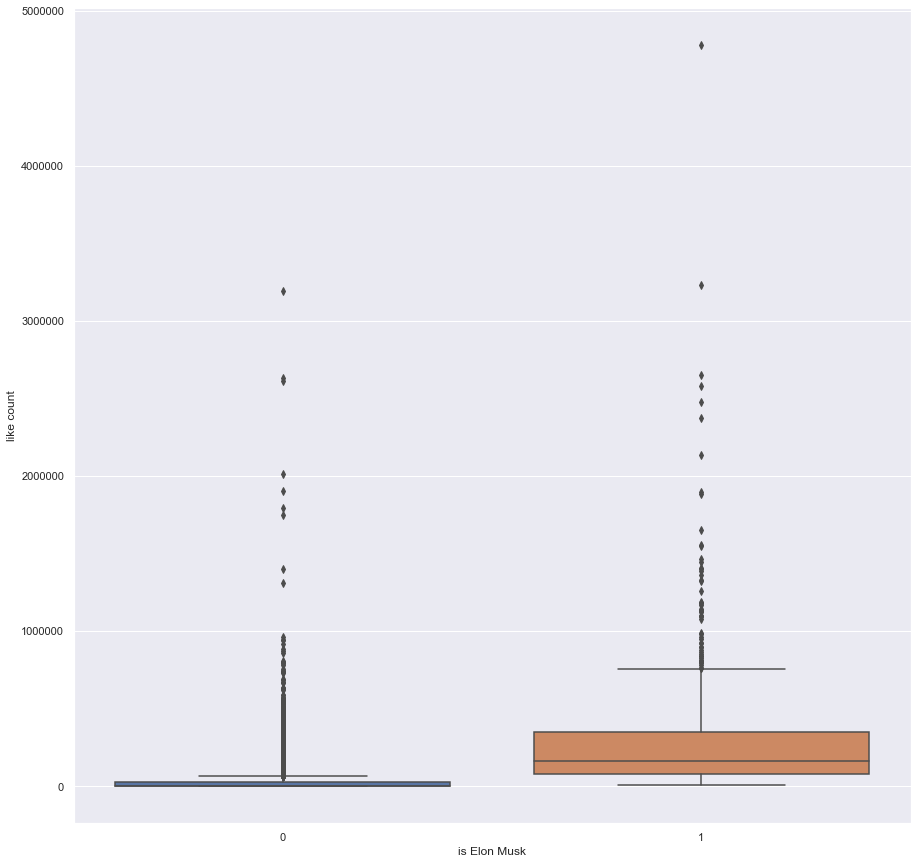

In [15]:
import seaborn as sb
sb.set(rc={"figure.figsize":(15, 15)})
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['like count'])

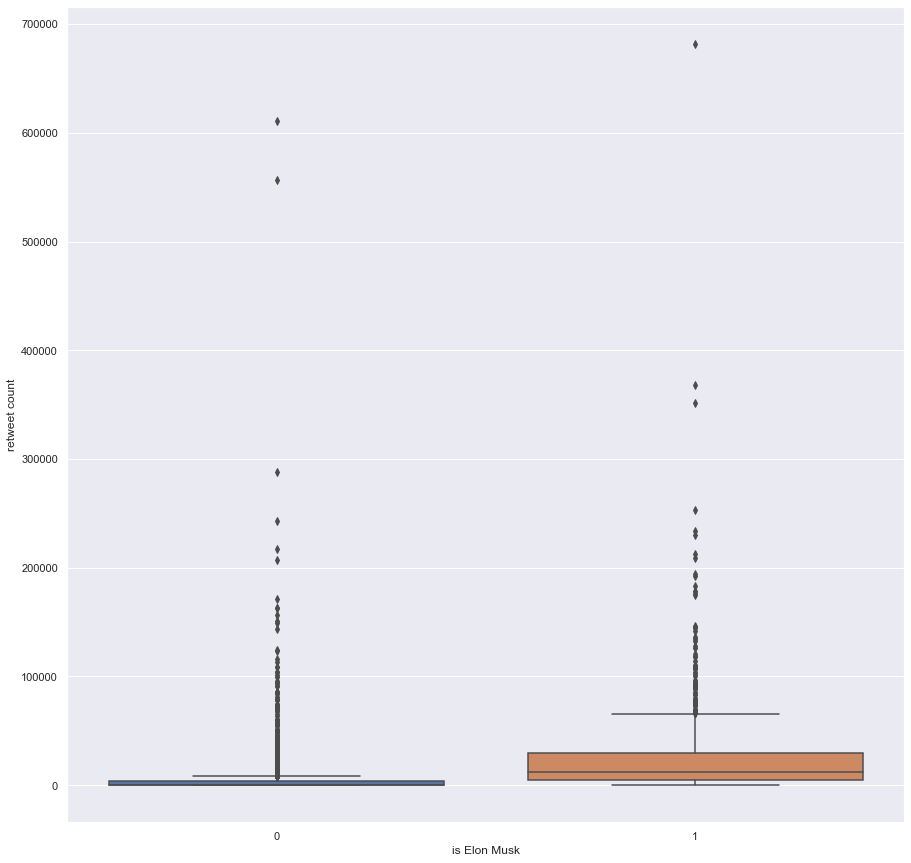

In [16]:
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['retweet count'])

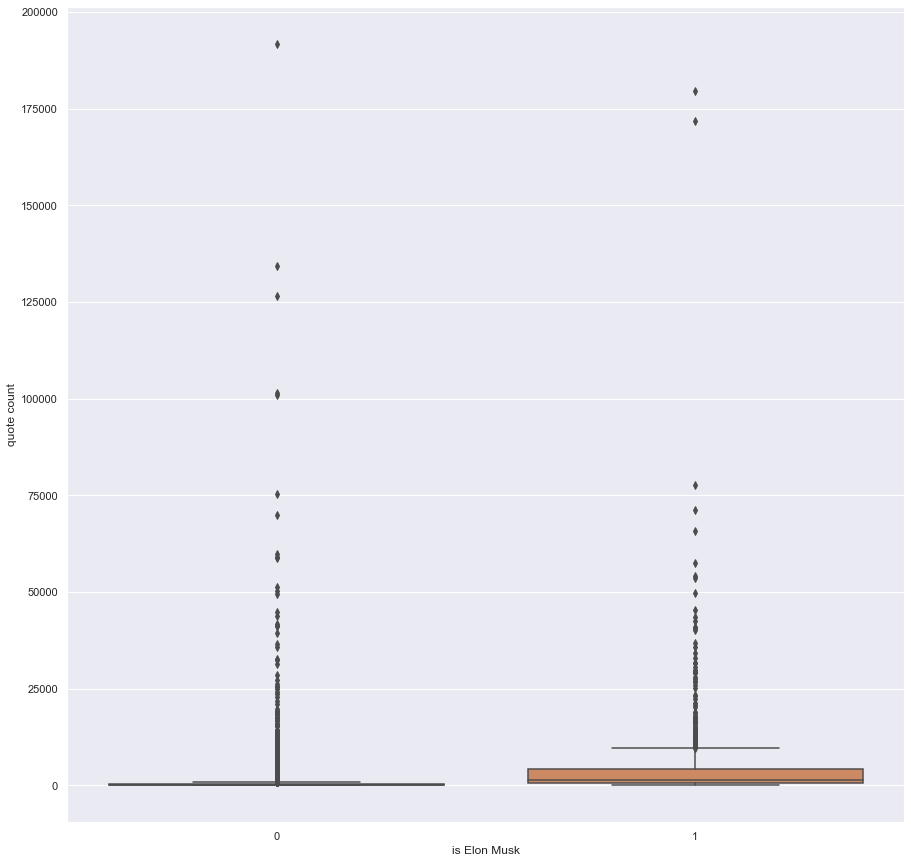

In [17]:
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['quote count'])

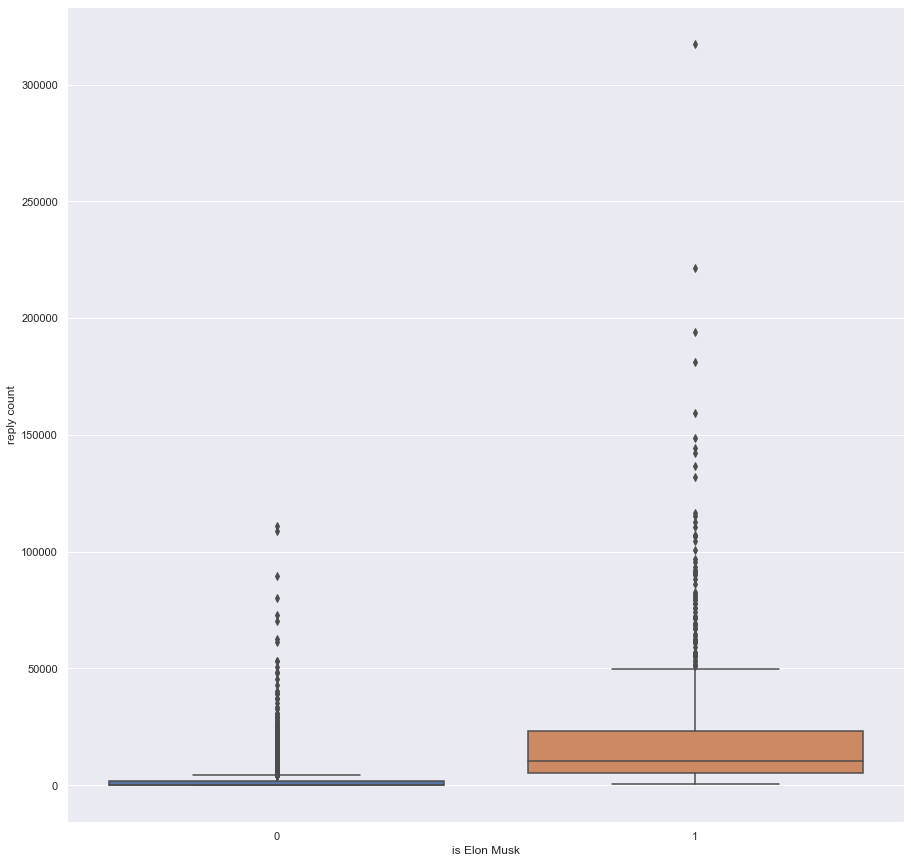

In [18]:
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['reply count'])

#### Sentyment

W obu przypadkach zarówno średniej jak i medianie wartości sentymentu wpisu są podobne. Wpisy neutralne. 

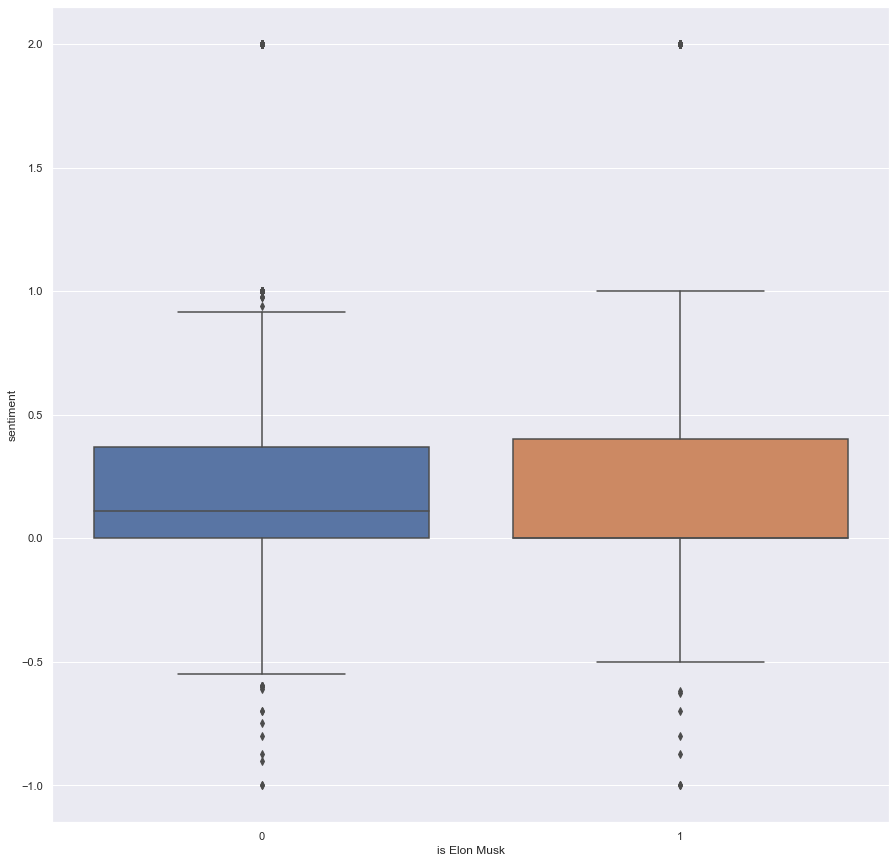

In [19]:
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['sentiment'])

#### Subiektywność  

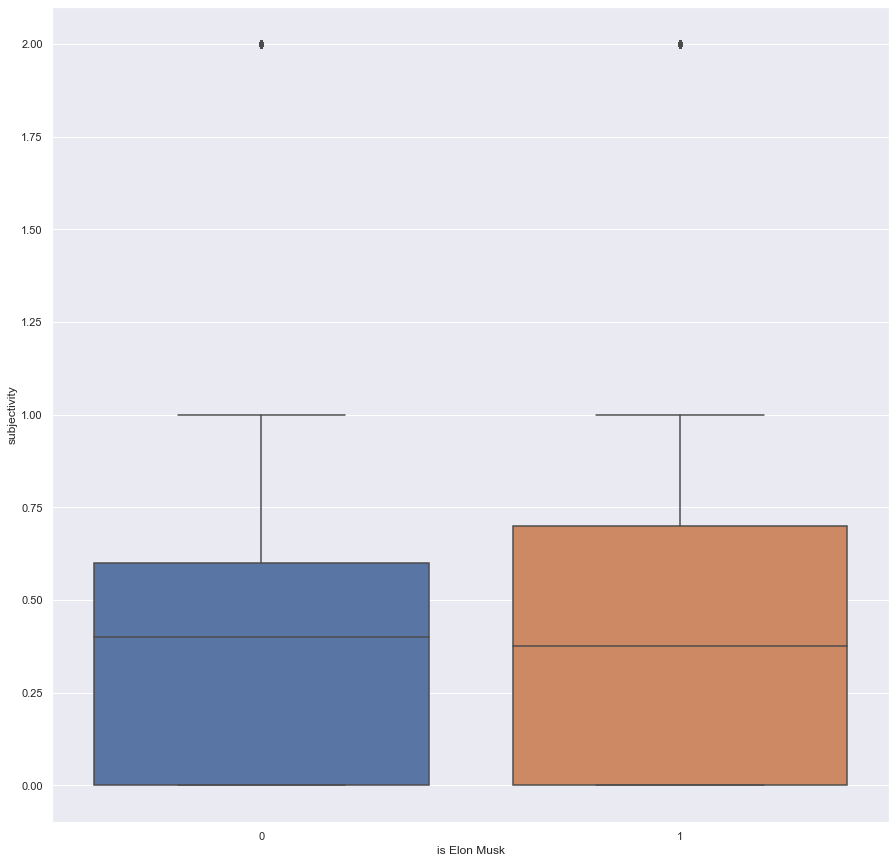

In [20]:
sb.boxplot(x=data_frame['is Elon Musk'], y=data_frame['subjectivity'])

In [21]:
data_frame_elon = data_frame.loc[data_frame['is Elon Musk'] == 1] 
data_frame_not_elon = data_frame.loc[data_frame['is Elon Musk'] == 0]

### Mapa cieplna

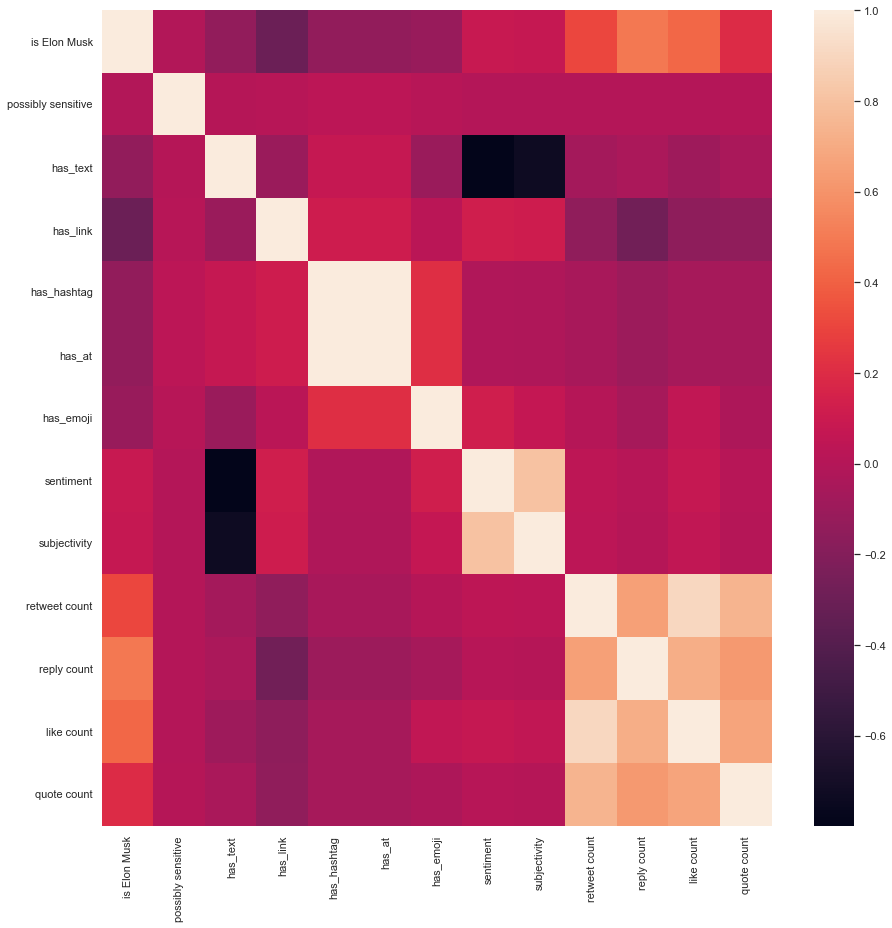

In [22]:
corr_matrix=data_frame.corr()
sb.heatmap(corr_matrix)

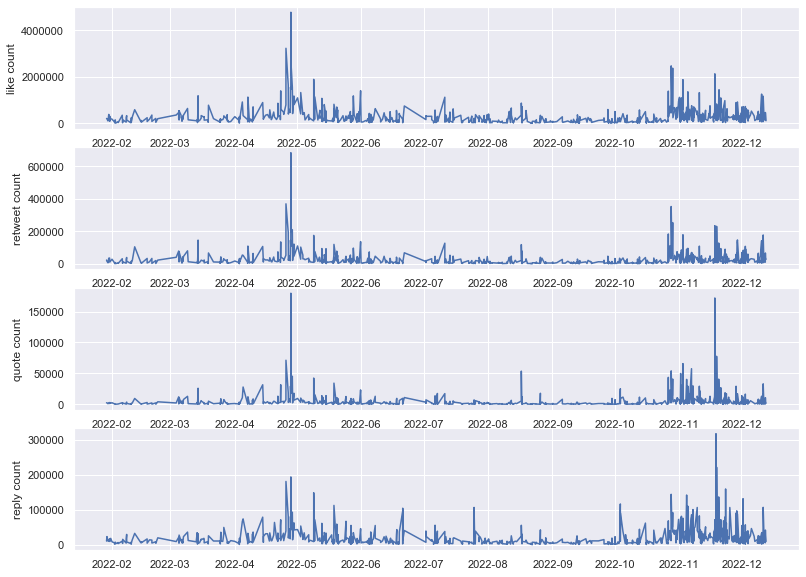

In [23]:
ylabels = ["like count","retweet count", 'quote count', 'reply count']

def plot_charts(data_frame, ylabels):
    fig = plt.figure(figsize=(13,10))
    fig.subplots_adjust(hspace=0.15,wspace=0.01)

    n_row = len(ylabels)
    n_col = 1
    for count, ylabel in enumerate(ylabels):
        ax = fig.add_subplot(n_row, n_col, count+1)
        ax.plot(data_frame["created at"].to_numpy(dtype='datetime64'), data_frame[ylabel].to_numpy())
        ax.set_ylabel(ylabel)

plot_charts(data_frame_elon, ylabels)

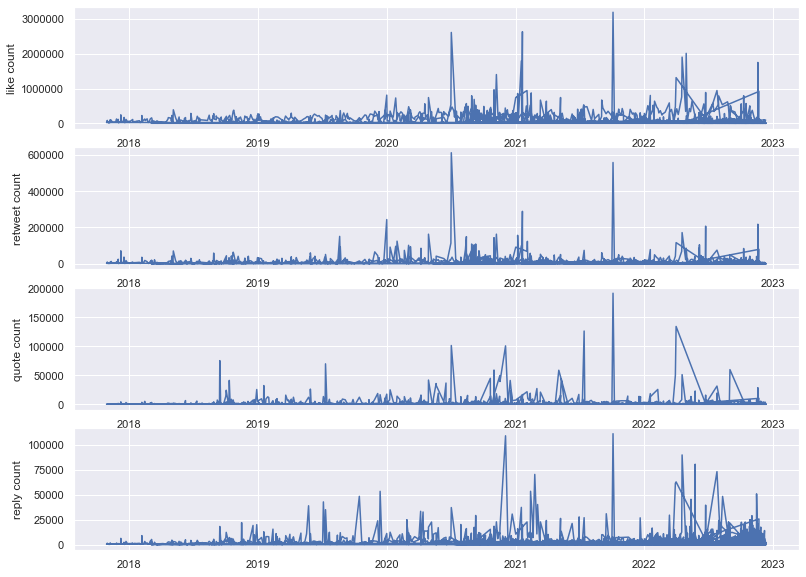

In [24]:
plot_charts(data_frame_not_elon, ylabels)

### Najbardziej popolrany wpis Elona Muska 


***Next I’m buying Coca-Cola to put the cocaine back in***

***the bird is freed***

#### Ilość wpisów w zależności od pory dnia


Sprawdzono ilość wpisów w zależności od godziny na przestrzeni doby.
W celu przeanalizowania tej zależności utworzono histogram wpisów w zależności od godziny.
Histogram został zamieszczony poniżej. Analizując histogram można zauważyć bardzo ciekawą zależność 
Elon Musk jest dużo bardziej aktywny od pozostałych użytkowników między 0 a 8. 
W pozostałych godzinach Elon jest mniej aktywny od pozostałych użytkowników.  


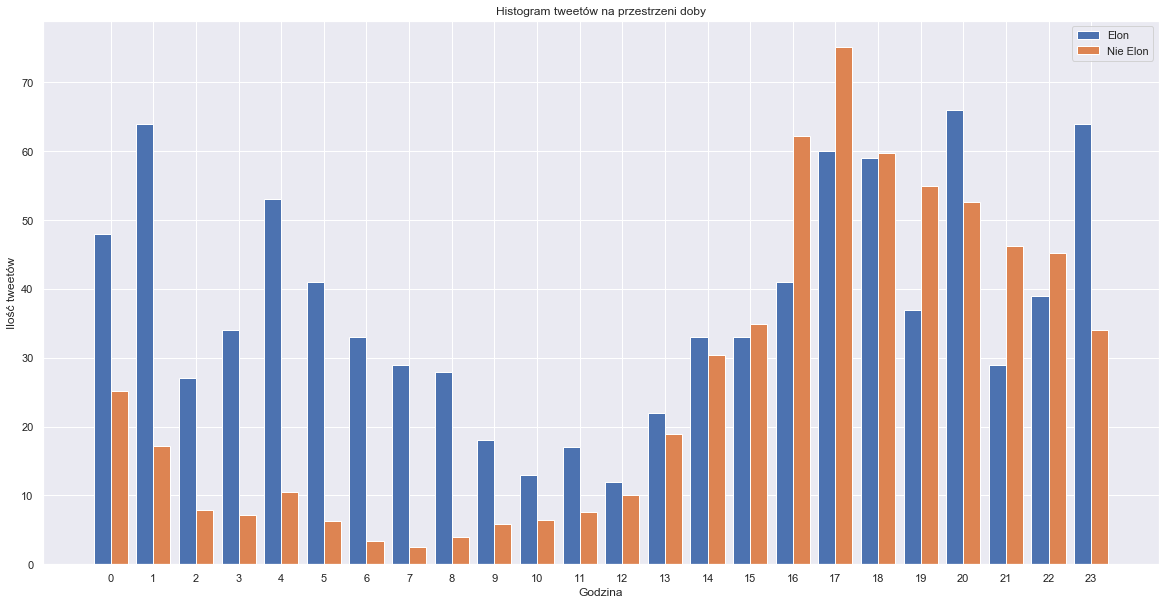

In [25]:

data_frame_not_elon_count_by_hour = data_frame_not_elon['created at'].groupby(data_frame_not_elon['created at'].dt.hour).count() / 10
elon_data_count_by_hour = data_frame_elon['created at'].groupby(data_frame_elon['created at'].dt.hour).count()

def fill_missing_hours_with_zero(data_count_by_hour_dict):
    for i in range(24):
        if i not in data_count_by_hour_dict:
            data_count_by_hour_dict[i] = 0
    
    data_count_by_hour_list = list(dict(sorted(data_count_by_hour_dict.items())).values())
    return np.array(data_count_by_hour_list).astype(float)

data_count_by_hour = fill_missing_hours_with_zero(data_frame_not_elon_count_by_hour.to_dict())

def plot_histogram_of_tweet_during_time(elon_data_count_by_hour, not_elon_data_count_by_hour, y_label, title):
    bar_width = 0.4
    hours = np.arange(24)
    plt.figure(figsize=(20, 10))
    plt.bar(hours - bar_width/2, elon_data_count_by_hour.values, width=bar_width, label='Elon')
    plt.bar(hours + bar_width/2, not_elon_data_count_by_hour, width=0.4, label='Nie Elon')

    plt.xticks(hours, hours)
    plt.xlabel("Godzina")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

plot_histogram_of_tweet_during_time(elon_data_count_by_hour, data_count_by_hour, 'Ilość tweetów', 'Histogram tweetów na przestrzeni doby')

### Analiza sentymentu w ciągu dnia

Analizując sentyment wpisów na przestrzeni doby. Można zaobserwować iż wpisy Elona Muska były wyjątkowe pozytywne 
o godzinie 10 oraz 12. W tylko w tych godzinach sentyment wpisów Elona Muska znacząco przewyższa średni sentyment
pozostałych użytkowników.     

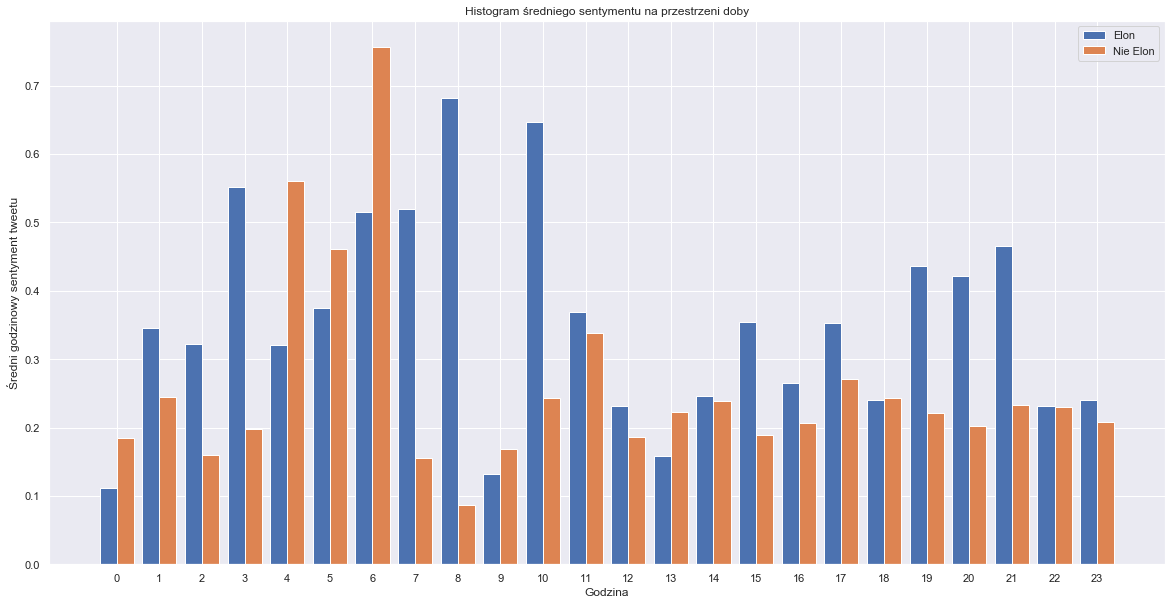

In [26]:
elon_sentiment = data_frame_elon.groupby(data_frame_elon['created at'].dt.hour).describe()['sentiment']['mean']
not_elon_sentiment = data_frame_not_elon.groupby(data_frame_not_elon['created at'].dt.hour).describe()['sentiment']['mean']

data_count_by_hour = fill_missing_hours_with_zero(not_elon_sentiment.to_dict())
plot_histogram_of_tweet_during_time(elon_sentiment, data_count_by_hour, 'Średni godzinowy sentyment tweetu', 'Histogram średniego sentymentu na przestrzeni doby')


### Analiza danych nienumerycznych

#### Źródło wpisu
Analizując zmienne nienumeryczne można zaobserwować ciekawe zależności. Rozważając źródło dodania wpisu można zauważyć, 
że Elon Musk zawsze dodaje wpisy z aplikacji mobilnej na IPhone. Pozostali użytkownicy dodawali wpisy z różnych źródeł.

In [27]:
data_frame.groupby(by='is Elon Musk')['source'].value_counts()

is Elon Musk  source              
0             Twitter Web App         1784
              Twitter for iPhone      1390
              Twitter Media Studio     928
              SocialFlow               807
              Sprout Social            647
              Sprinklr                 579
              Twitter Web Client       147
1             Twitter for iPhone       900
Name: source, dtype: int64

([<matplotlib.patches.Wedge at 0x7f86d5a8f4c0>],
 [Text(-1.1, 1.3471114790620887e-16, 'Twitter for iPhone')],
 [Text(-0.6, 7.347880794884119e-17, '100.00%\n900.00')])

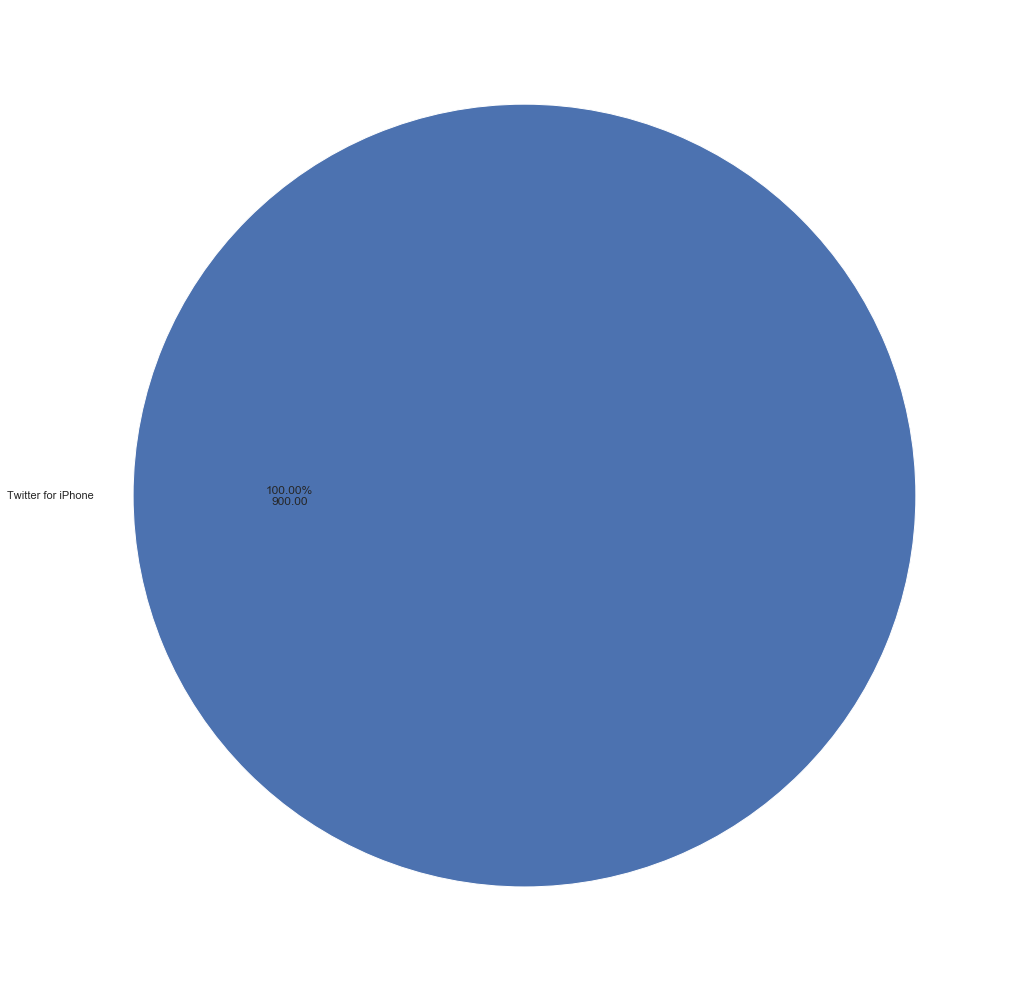

In [28]:
def fmt(x):
    return f'{x:.2f}%\n{total*x/100:.2f}'
plt.figure(figsize=(18,18))

total = data_frame_elon['source'].value_counts().values.sum()
plt.pie(data_frame_elon['source'].value_counts().values, labels=data_frame_elon['source'].value_counts().index, autopct=fmt)


([<matplotlib.patches.Wedge at 0x7f86d5a49610>,
 [Text(0.6904981532317562, 0.8562781676438646, 'Twitter Web App'),
  Text(-0.8675564538538599, 0.6762734649359796, 'Twitter for iPhone'),
  Text(-0.9668693245541231, -0.5245604914938351, 'Twitter Media Studio'),
  Text(-0.22504244353921807, -1.0767339033419066, 'SocialFlow'),
  Text(0.5476163731375299, -0.9540001613583186, 'Sprout Social'),
  Text(0.996822345251068, -0.46512924226300867, 'Sprinklr'),
  Text(1.0970289889380949, -0.08079231045997855, 'Twitter Web Client')],
 [Text(0.37663535630823064, 0.4670608187148352, '28.40%\n1784.00'),
  Text(-0.47321261119301444, 0.36887643541962517, '22.13%\n1390.00'),
  Text(-0.5273832679386126, -0.28612390445118274, '14.77%\n928.00'),
  Text(-0.12275042374866439, -0.5873094018228581, '12.85%\n807.00'),
  Text(0.29869983989319804, -0.5203637243772646, '10.30%\n647.00'),
  Text(0.5437212792278552, -0.25370685941618654, '9.22%\n579.00'),
  Text(0.598379448511688, -0.04406853297817011, '2.34%\n147.00')

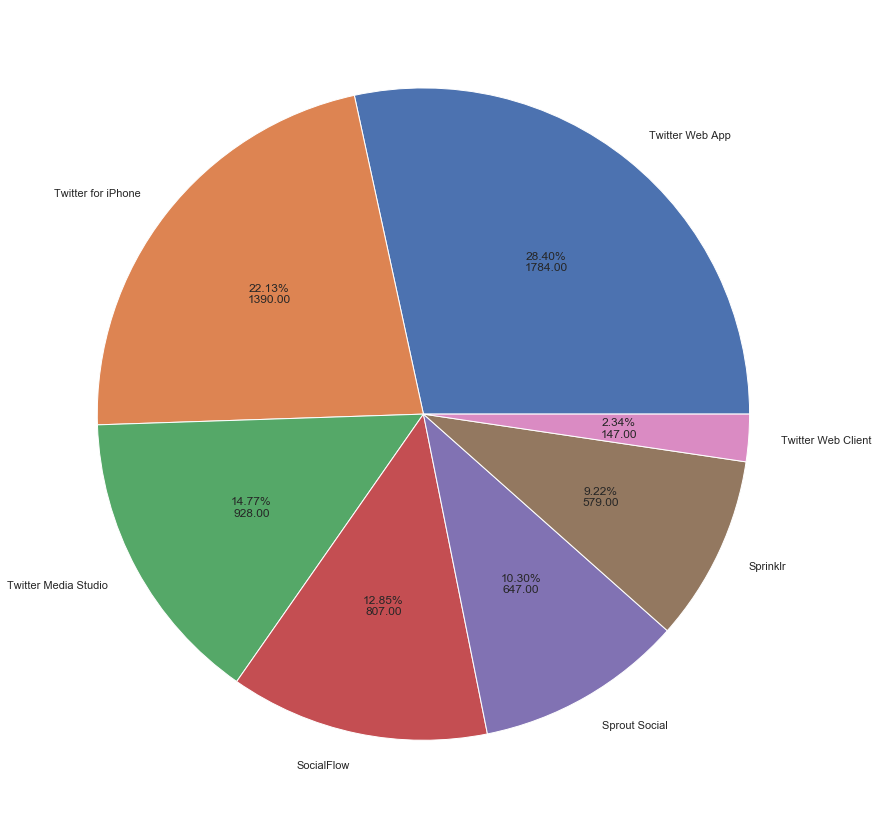

In [29]:
total = data_frame_not_elon['source'].value_counts().values.sum()
plt.pie(data_frame_not_elon['source'].value_counts().values, labels=data_frame_not_elon['source'].value_counts().index, autopct=fmt)


##### Język wpisu

Analizując języki wpisu, widać iż w obu przypadkach dominuje język angielski. Wpisy Elona Muska w zauważalnej części,
nie mają językowej zawartości(wpis jest pusty), takie wpisy to około 10% całej aktywności. Podobne zjawisko nie zachodzi
w przypadku pozostałych użytkowników. 

In [30]:
data_frame.groupby(by='is Elon Musk')['lang'].value_counts()

is Elon Musk  lang
0             en      6092
              art      101
              zxx       89
1             en       795
              zxx      100
              art        5
Name: lang, dtype: int64

([<matplotlib.patches.Wedge at 0x7f86d5a20a30>,
 [Text(-1.0269384593047584, 0.394204770139542, 'en'),
  Text(1.0199022205188684, -0.4120673010330737, 'zxx'),
  Text(1.0998324638213786, -0.01919769581476827, 'art')],
 [Text(-0.5601482505298682, 0.21502078371247743, '88.33%\n795.00'),
  Text(0.5563103021012008, -0.22476398238167655, '11.11%\n100.00'),
  Text(0.5999086166298427, -0.010471470444419055, '0.56%\n5.00')])

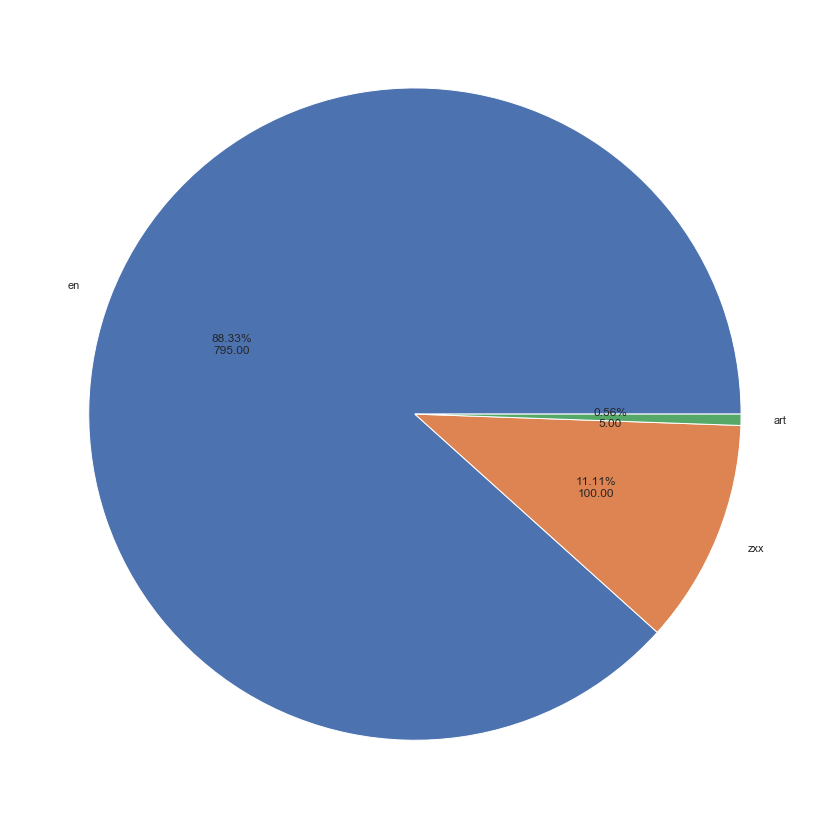

In [31]:
total = data_frame_elon['lang'].value_counts().values.sum()
plt.pie(data_frame_elon['lang'].value_counts().values, labels=data_frame_elon['lang'].value_counts().index, autopct=fmt)

([<matplotlib.patches.Wedge at 0x7f86d59e0eb0>,
 [Text(-1.0950381179342563, 0.1043624466510912, 'en'),
  Text(1.0893102009549673, -0.1529813259697049, 'art'),
  Text(1.0989106373439455, -0.04894293751220981, 'zxx')],
 [Text(-0.5972935188732307, 0.056924970900595194, '96.98%\n6092.00'),
  Text(0.5941692005208912, -0.08344435961983904, '1.61%\n101.00'),
  Text(0.5994058021876065, -0.026696147733932623, '1.42%\n89.00')])

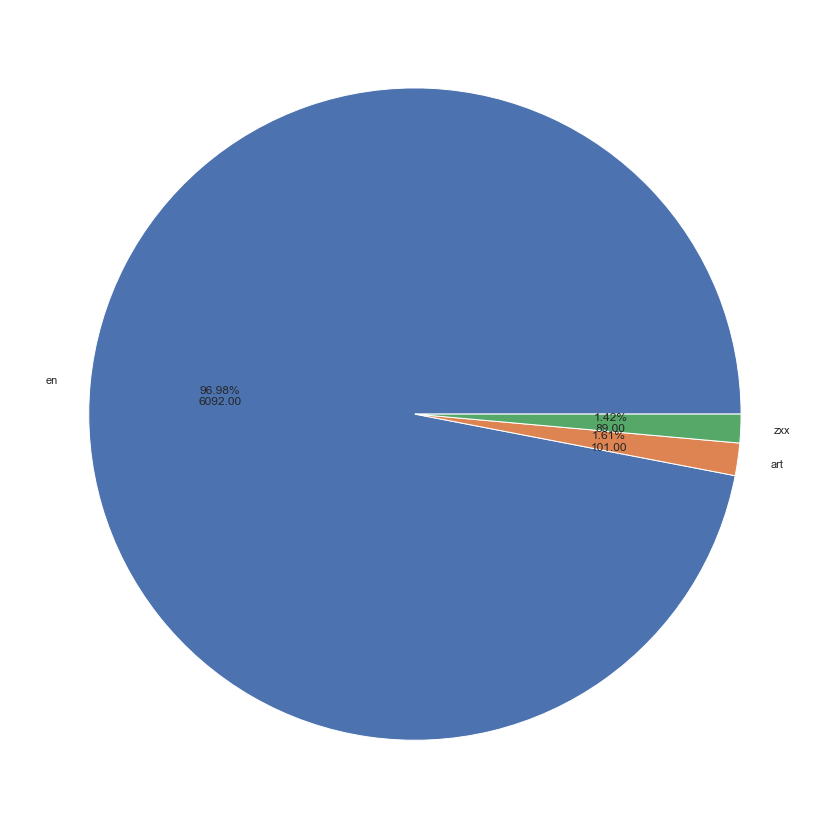

In [32]:
total = data_frame_not_elon['lang'].value_counts().values.sum()
plt.pie(data_frame_not_elon['lang'].value_counts().values, labels=data_frame_not_elon['lang'].value_counts().index, autopct=fmt)

### Reszta potencjalnych analiz

In [33]:
data_frame.groupby(by='is Elon Musk')['context annotations domain 0'].value_counts()

is Elon Musk  context annotations domain 0  
0             Person                            2726
              Unified Twitter Taxonomy           773
              TV Genres                          559
              Entities [Entity Service]          502
              Business Taxonomy                  313
              TV Shows                           291
              Events [Entity Service]            259
              Ongoing News Story                 228
              News Vertical                      101
              Sports Event                        85
              Brand Vertical                      77
              Interests and Hobbies Vertical      54
              Sports League                       50
              Interests and Hobbies               45
              Political Body                      39
              Sports Team                         39
              States                              36
              Brand                               25
 

In [34]:
import plotly.express as px

fig = px.histogram(data_frame, y='context annotations domain 0', color='is Elon Musk', barmode='group', histfunc='avg', height=800)
fig.show()

In [35]:
data_frame.groupby(by='is Elon Musk')['context annotations entity 0'].value_counts()

is Elon Musk  context annotations entity 0
0             Joe Biden                       579
              Talk shows                      557
              Social media                    538
              Kim Kardashian                  447
              Services                        433
                                             ... 
1             TikTok                            1
              Top Gun: Maverick                 1
              Transportation                    1
              Truth Social                      1
              Vikings                           1
Name: context annotations entity 0, Length: 739, dtype: int64

In [36]:
fig = px.histogram(data_frame, y='context annotations entity 0', color='is Elon Musk', barmode='group', histfunc='avg', height=2000)
fig.show()

In [37]:
ddd

NameError: name 'ddd' is not defined



Na podstawie niżej wymienionych zmiennych będzie wykonywana klasyfikacja binarna tweetów Elona Muska:

* is Elon Musk - zmienna określa czy wpis należał do Elona Muska, jest kluczowa będzie wykorzystywana jako etykieta w trakcie klasyfikacji 
* source - źródło wpisu, czy jest to aplikacja czy strona *www*, z analizy danych zostało zauważone iż Elon dodaje wpisy tylko z aplikacji 
* lang	- język wpisu, w przypadku wpisów Elona duża część ma kategorie `und` (niezdefiniowany) 
* has_text - informacja czy tweet zawiera czysty tekst, bez linków, hashtagów czy emoji 
* has_link - informacja czy tweet zawiera link 
* has_hashtag - informacja czy tweet zawiera jakiś hashtag 
* has_at - informacja czy w wpisie byli oznaczeni inni użytkownicy 
* has_emoji	- informacja czy tweet zawiera emocji
* sentiment	- sentyment wpisu, obliczane tylko dla anglojęzycznych wpisów, bez emoji, linków, itd. Gdy tekst po oczyszczeniu jest pusty sentyment przyjmuje wartość dwa 
* retweet count	- liczba retweetów, Elon Musk miał średnio więcej retweetów
* reply count - liczba odpowiedzi, Elon Musk miał średnio więcej odpowiedzi
* like count - liczba polubień, Elon Musk miał średnio więcej polubień
* quote count - liczba cytowań, Elon Musk miał średnio więcej cytowań	

Dodatkowo zostaną wzięte pod uwagę konteksty wypowiedzi ich dziedzina oraz podmiot(tylko trzy pierwsze z 6 możliwych):

* context annotations domain 0
* context annotations entity 0 	
* context annotations domain 1 
* context annotations entity 1 	
* context annotations domain 2
* context annotations entity 2

Informacje te będą przydatne ponieważ będą świadczyć o czym najczęściej pisze Elon Musk.

W zadaniu klasyfikacji zmienna **is Elon Musk** będzie etykietą reszta natomiast będzie zestawem cech, na podstawie których 
przygotowane modele będą dokonywać klasyfikacji. 
#### Dobroć modelu


W przypadku klasyfikacji tweetów Elona Muska zmagamy się z problemem niezbilansowanego zbioru danych, 
wpisy Elona Muska stanowią między innymi około 12%. W takim przypadku poleganie na dokładności klasyfikacji może dawać
fałszywe poczucie dobrego działania modelu(model może osiągnąć wysoką dokładność, klasyfikując wszystkie próbki jako klasę dominującą).
 Do analizy działania modelu zostały wykorzystane następujące wskaźniki:

* Tablica pomyłek 
* Precyzja 
* Zwrot 
* Dokładność 
* Krzywe uczenia 


In [ ]:
used_annotations_domain = 3
used_annotations_entity = 0
annotations = 6
    
columns_to_be_dropped = [
    'created at',
    'possibly sensitive',
    'annotations',
    'retweet count',
    'reply count',
    'like count',
    'quote count']

def add_annotations_columns_to_be_dropped(annotations, used_annotations, column_specific_name):
    for i in range(annotations - used_annotations):
        colum = f'context annotations {column_specific_name} {used_annotations + i}'
        columns_to_be_dropped.extend([colum])

add_annotations_columns_to_be_dropped(annotations, used_annotations_entity, 'entity')
add_annotations_columns_to_be_dropped(annotations, used_annotations_domain, 'domain')


data_frame = data_frame.loc[:,~data_frame.columns.duplicated()].copy()
data_frame.drop(columns_to_be_dropped, axis=1, inplace=True)

#### Wygląd ramki danych

In [ ]:
data_frame.head()

,is Elon Musk,source,lang,has_text,has_link,has_hashtag,has_at,has_emoji,sentiment,subjectivity,...,Sports Team,States,TV Channels,TV Episodes,TV Genres,TV Shows,Technology,Unified Twitter Taxonomy,Video Game,Video Game Hardware
0,1,14,25,0,1,0,0,1,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,1,14,6,1,1,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,14,6,1,0,0,0,0,0.8,0.7,...,0,0,0,0,0,0,0,0,0,0
3,1,14,6,1,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,14,6,1,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def remove_null_annotations(used_annotations, column_specific_name, df):
    for i in range(used_annotations):
        col = f'context annotations {column_specific_name} {i}'
        df = df[df[col].notnull()]
        
    return df

def add_columns_to_be_merged(columns_to_be_merged, used_annotations, column_specific_name):
    for i in range(used_annotations):
        col = f'context annotations {column_specific_name} {i}'
        columns_to_be_merged.extend([col])
    
    return columns_to_be_merged

def map_value(value):
    if value == 0:
        return 0
    return 1

def hot_one_encode_annotation_columns(columns_list, data_frame, map_value):
    frame = pd.DataFrame()
    frame = pd.concat([frame, pd.get_dummies(data_frame[columns_list].astype(str), prefix='', prefix_sep='')], axis=1)
    frame = frame.groupby(by=frame.columns, axis=1).sum()
    frame = frame.applymap(map_value)
    data_frame.drop(columns_list, axis=1, inplace=True)
    return pd.concat([data_frame, frame], axis=1)


data_frame = remove_null_annotations(used_annotations_domain, 'domain', data_frame)
data_frame = remove_null_annotations(used_annotations_entity, 'entity', data_frame)
columns_to_be_merged = []
columns_to_be_merged = add_columns_to_be_merged(columns_to_be_merged, used_annotations_domain, 'domain')
columns_to_be_merged = add_columns_to_be_merged(columns_to_be_merged, used_annotations_entity, 'entity')

data_frame = hot_one_encode_annotation_columns(columns_to_be_merged, data_frame, map_value) 

In [ ]:
from sklearn.preprocessing import LabelEncoder 
import sklearn

for col in ['source', 'lang']:
    le = LabelEncoder()
    data_frame[col]= le.fit_transform(data_frame[col])


#### Przykład zakodowanych danych

In [ ]:
data_frame.head()

,is Elon Musk,source,lang,has_text,has_link,has_hashtag,has_at,has_emoji,sentiment,subjectivity,...,Sports Team,States,TV Channels,TV Episodes,TV Genres,TV Shows,Technology,Unified Twitter Taxonomy,Video Game,Video Game Hardware
0,1,14,25,0,1,0,0,1,2.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,1,14,6,1,1,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,14,6,1,0,0,0,0,0.8,0.7,...,0,0,0,0,0,0,0,0,0,0
3,1,14,6,1,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1,14,6,1,0,0,0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0



#### Podział danych na etykiety i zbiór cech

Etykiety są wartościami pobranymi z pierwszej kolumny, pozostałe kolumny to wartości wektora cech. 

In [ ]:
y = data_frame.iloc[:, 0]
x = data_frame.iloc[:, 1:]

#### Podział na zbiór testowych oraz treningowy

Przygotowane dane są podzielone w następujący sposób:
* 80% - zbiór treningowy
* 20% - zbiór testowy

Dodatkowo wykorzystany zostaje parametr **stratify**, który pozwoli zachować proporcje między klasami w zbiorze treningowym oraz  testowym.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

#### Wielowarstwowy Perceptron

Jako pierwszy model zastosowano wielowarstwowy perceptron. Obserwując wyniki klasyfikacji można zauważyć takie cechy jak:
* Największy problem widać w macierzy pomyłek, gdzie widać przypadki FP oraz FN, czyli przypisano 52 próbek z klasy pierwszej(nie Elon)
do klasy drugiej(Elon) oraz 8 z klasy drugiej do klasy pierwszej.
* Współczynniki czułości w obu przypadkach przewyższa 0.90, podniesienie wartości precyzji polepszyłoby działanie modelu  
* Wysoką dokładność 


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

mlp_classifier = MLPClassifier(hidden_layer_sizes = (150, 50), random_state = 42, activation= 'tanh', max_iter=1000)
mlp_classifier.fit(x_train, y_train)

labels_predicted_mlp = mlp_classifier.predict(x_test)

print(f'MLPClassifier accuracy:  {100*accuracy_score(labels_predicted_mlp, y_test)}[%]')
print(classification_report(y_test, labels_predicted_mlp))
print(confusion_matrix(y_test, labels_predicted_mlp))

MLPClassifier accuracy:  98.37877671333824[%]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1177
           1       0.90      0.98      0.94       180

    accuracy                           0.98      1357
   macro avg       0.95      0.98      0.97      1357
weighted avg       0.98      0.98      0.98      1357

[[1158   19]
 [   3  177]]


In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(
    estimator,
    X,
    y,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    

    plt.title('Krzywa uczenia oraz krzywa walidacji')
    plt.xlabel("Liczba próbek")
    plt.ylabel("Dokładność")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
   
    plt.grid()
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Dokładność uczenia"
    )
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Dokładność walidacji krzyżowej"
    )
    plt.legend(loc="best")
    plt.show()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

#### Krzywa uczenia 

Analizując krzywą uczenia można zauważyć dwie główne cechy:
* Zwiększanie ilości obserwacji nie poprawia dokładności
* Krzywa uczenia nie ma symptomów przeuczenia, dokładność zbioru treningowego jest zbliżona do zbioru testowego  

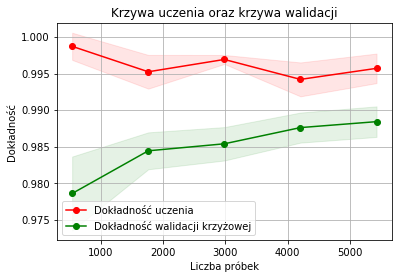

In [ ]:
plot_learning_curve(mlp_classifier, x, y, cv=cv, n_jobs=4)

#### Drzewo Decyzyjne

Jako drugi model wykorzystano drzewo decyzyjne.Obserwując wyniki klasyfikacji można zauważyć:
* Klasyfikator prawie się nie mylił na zbiorze testowym blednie zaklasyfikował tylko 15 próbek.
* Obie wartości precyzji i zwrotu osiągają wartości bliskie 1
* Dokładność na poziomie 99%

In [ ]:
from sklearn import tree

tree_cls = tree.DecisionTreeClassifier()
tree_cls = tree_cls.fit(x_train, y_train)

labels_predicted_tree = tree_cls.predict(x_test)
print(f'DecisionTreeClassifier accuracy:  {100*accuracy_score(labels_predicted_tree, y_test)}[%]')
print(classification_report(y_test, labels_predicted_tree))
print(confusion_matrix(y_test, labels_predicted_tree))

DecisionTreeClassifier accuracy:  97.8629329403095[%]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1177
           1       0.91      0.93      0.92       180

    accuracy                           0.98      1357
   macro avg       0.95      0.96      0.95      1357
weighted avg       0.98      0.98      0.98      1357

[[1160   17]
 [  12  168]]



#### Krzywa uczenia 

Analizując krzywą uczenia można zauważyć dwie główne cechy:
* Zwiększanie ilości obserwacji poprawia dokładność zbioru testowego 
* Krzywa uczenia może wyglądać jakby model był przeuczony jednak różnica między  zbiorem testowym a treningowym w finalnej fazie wynosi mniej niż 0.15%

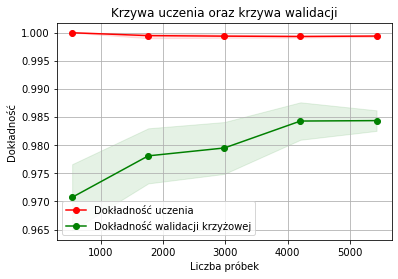

In [ ]:
plot_learning_curve(tree_cls, x, y, cv=cv, n_jobs=4)

#### Reprezentacja drzewa edycyjnego

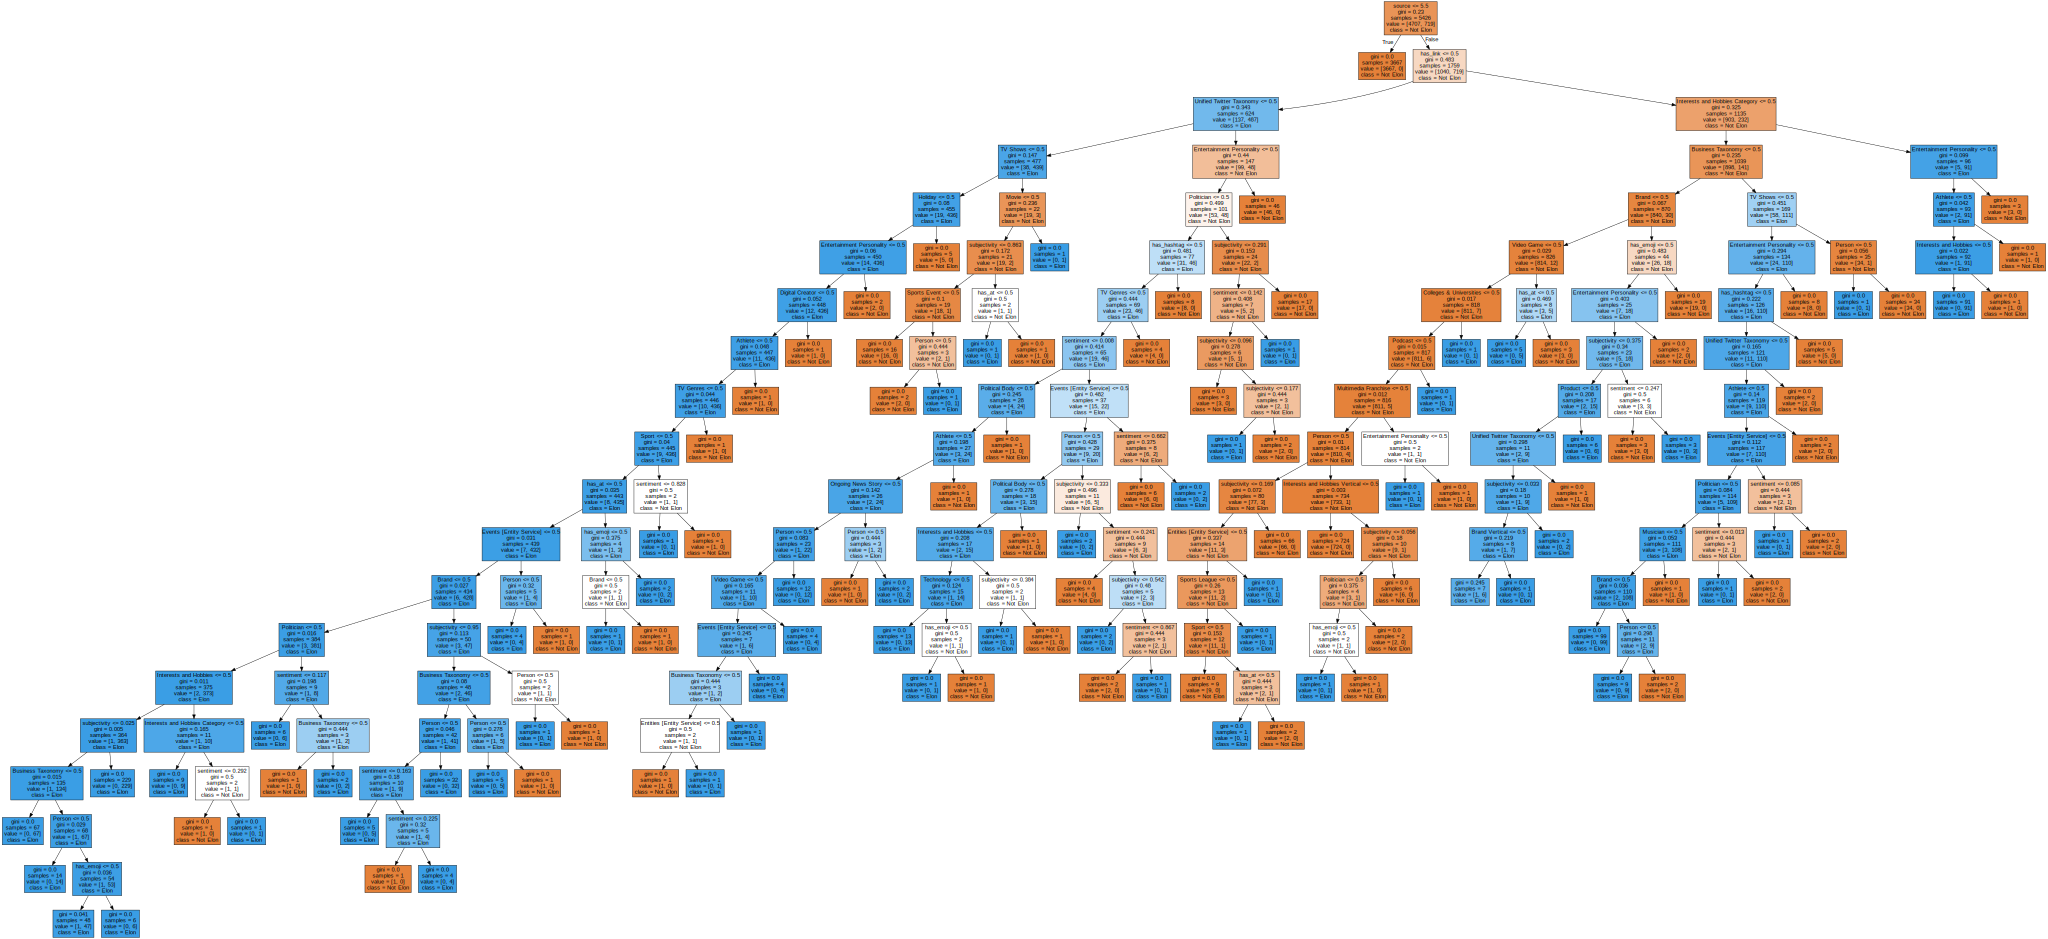

In [ ]:
import graphviz
dot_data = tree.export_graphviz(tree_cls, filled=True, feature_names = x.columns.values.tolist(), class_names = ['Not Elon', 'Elon'])
graph = graphviz.Source(dot_data, format="png") 
graph

### Podsumowanie


Wybrane zmienne pozwoliły osiągnąć bardzo skuteczne modele. Analiza macierzy pomyłek uwydatniła problem niezbalansowanego 
zbioru danych. Klasyfikator oparty o drzewa decyzyjne dał dużo lepszy rezultat. Dalsza praca nad doborem hiperparametrów
oraz wybranie lepszego zbioru cech może usprawnić działanie klasyfikatorów   